# LangGraph-Building-Graphs

## Steps for Defining a Graph  
To define a graph with `LangGraph`, you need to define **State** , **Node** , and **Graph** , and then compile them.  

If necessary, you can flexibly adjust the graph flow by adding conditional edges to nodes using `add_conditional_edges()`.

### Define State  

**State** defines the shared state between the nodes in the graph.  

It uses the `TypedDict` format and adds metadata to type hints using `Annotated` to provide detailed information.

In [1]:
from typing import TypedDict, Annotated, List
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]
    answer: Annotated[List[Document], operator.add]
    question: Annotated[str, "User question"]
    sql_query: Annotated[str, "sql query"]
    binary_score: Annotated[str, "binary score yes or no"]


### Define Node  
Define the nodes that process each step.  

These are usually implemented as Python functions, with **State** as both input and output.

In [2]:
def retrieve(state: GraphState) -> GraphState:
    # retrieve: search
    documents = "searched documents"
    return {"context": documents} #type: ignore

def rewrite_query(state: GraphState) -> GraphState:
    # Query Transform: rewrite query
    documents = "searched documents"
    return GraphState(context=documents) # type: ignore

def llm_gpt_execute(state: GraphState) -> GraphState:
    # LLM Execution
    answer = "GPT generated answer"
    return GraphState(answer=answer) # type: ignore


def llm_claude_execute(state: GraphState) -> GraphState:
    # LLM Execution
    answer = "Claude generated answer"
    return GraphState(answer=answer) # type: ignore


def relevance_check(state: GraphState) -> GraphState:
    # Relevance Check
    binary_score = "Relevance Score"
    return GraphState(binary_score=binary_score) # type: ignore


def sum_up(state: GraphState) -> GraphState:
    # sum_up: Aggregate Results
    answer = "Aggregate Results"
    return GraphState(answer=answer) # type: ignore


def search_on_web(state: GraphState) -> GraphState:
    # Search on Web
    documents = state["context"] = "existing documents" # type: ignore
    searched_documents = "searched documents"
    documents += searched_documents
    return GraphState(context=documents) # type: ignore


def get_table_info(state: GraphState) -> GraphState:
    # Get Table Info
    table_info = "table information"
    return GraphState(context=table_info) # type: ignore


def generate_sql_query(state: GraphState) -> GraphState:
    # Make SQL Query
    sql_query = "SQL query"
    return GraphState(sql_query=sql_query) # type: ignore


def execute_sql_query(state: GraphState) -> GraphState:
    # Execute SQL Query
    sql_result = "SQL result"
    return GraphState(context=sql_result) # type: ignore


def validate_sql_query(state: GraphState) -> GraphState:
    # Validate SQL Query
    binary_score = "SQL query validation result"
    return GraphState(binary_score=binary_score) # type: ignore


def handle_error(state: GraphState) -> GraphState:
    # Error Handling
    error = "error occurred"
    return GraphState(context=error) # type: ignore


def decision(state: GraphState) -> GraphState:
    # Decision Making
    decision = "decision"
    # Additional logic can be added here.

    if state["binary_score"] == "yes":
        return "exit" # type: ignore
    else:
        return "re_search" # type: ignore

### Define Graph  
Connect nodes with **Edge** .  

Using conditional edges, you can determine the next **Node** to execute based on the current **State** . 

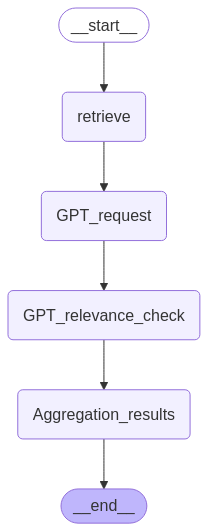

In [3]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")
workflow.add_edge("Aggregation_results", END)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

# Visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))


## Various Graph Structures  

In this section, you will learn about different graph structures using conditional edges.

The graph structures you will learn are as follows:
1. Re-search graph structure
2. Multi-LLM graph structure
3. Query rewrite graph structure
4. SQL RAG graph structure

### Re-search Graph Structure
Đồ thị Re-search (Tìm kiếm lại) kiểm tra đầu ra từ mô hình GPT và chọn `re_search` hoặc `exit`. Điều này cho phép bạn thu được kết quả phù hợp hơn cho truy vấn.

Luồng thực thi như sau:

- Một cạnh điều kiện được thêm vào nút `Aggregation_results` (Tổng hợp kết quả).
- Nút `GPT_relevance_check` (Kiểm tra độ phù hợp của GPT) kiểm tra độ phù hợp của đầu ra từ nút `GPT_request` (Yêu cầu GPT).
- Dựa trên kết quả kiểm tra độ phù hợp, nút `Aggregation_results` quyết định `re_search` hoặc `exit` bằng cách sử dụng thông tin **State** (Trạng thái).


In [5]:
# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")

# Add conditional edges.
workflow.add_conditional_edges(
    "Aggregation_results",  # Pass the result from the relevance check node to the decision function.
    decision,
    {
        "re_search": "retrieve",  # If the relevance check result is ambiguous, generate the answer again.
        "exit": END,  # If relevant, exit.
    },
)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

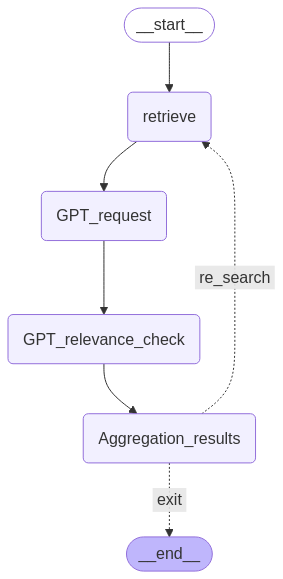

In [8]:
app

### Multi-LLM Graph Structure  
The Multi-LLM graph uses various LLM models to generate results.

This allows for obtaining a variety of answers.

In [12]:
del app

In [13]:
# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)

# add a new node for Claude
workflow.add_node("Claude_request", llm_claude_execute)
# add a new node for checking Claude's relevance
workflow.add_node("Claude_relevance_check", relevance_check)

workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")

# connect the new node to the entry point
workflow.add_edge("retrieve", "Claude_request")
# connect the "Claude_request" node to the "Claude_relevance_check"
workflow.add_edge("Claude_request", "Claude_relevance_check")
workflow.add_edge("Claude_relevance_check", "Aggregation_results")
workflow.add_edge("Aggregation_results", END)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

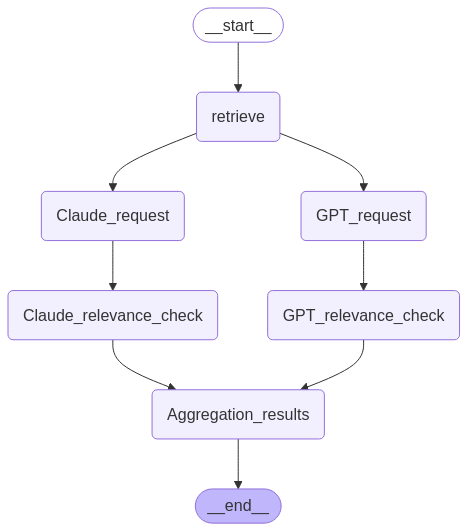

In [14]:
app

In [15]:
del app

### Query Rewrite Graph  
Đồ thị Viết lại Truy vấn (Query Rewrite Graph) là một cấu trúc thêm node `rewrite_query` vào cấu trúc Đồ thị Tìm kiếm lại (Re-search Graph).

Node rewrite (node viết lại) cho truy vấn viết lại câu hỏi để thu được kết quả tinh chỉnh hơn.


In [16]:
# Import StateGraph and END from langgraph.graph.
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)

# add a new node for rewriting the query
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("Claude_request", llm_claude_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Claude_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)

# Connect nodes.
workflow.add_edge("retrieve", "GPT_request")
workflow.add_edge("retrieve", "Claude_request")
workflow.add_edge("rewrite_query", "retrieve")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")
workflow.add_edge("Claude_request", "Claude_relevance_check")
workflow.add_edge("Claude_relevance_check", "Aggregation_results")

# Add conditional edges. (4)
workflow.add_conditional_edges(
    "Aggregation_results",  # Pass the result from the relevance check node to the decision function.
    decision,
    {
        "re_search": "rewrite_query",  # If the relevance check result is ambiguous, generate the answer again.
        "exit": END,  # If relevant, exit.
    },
)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)


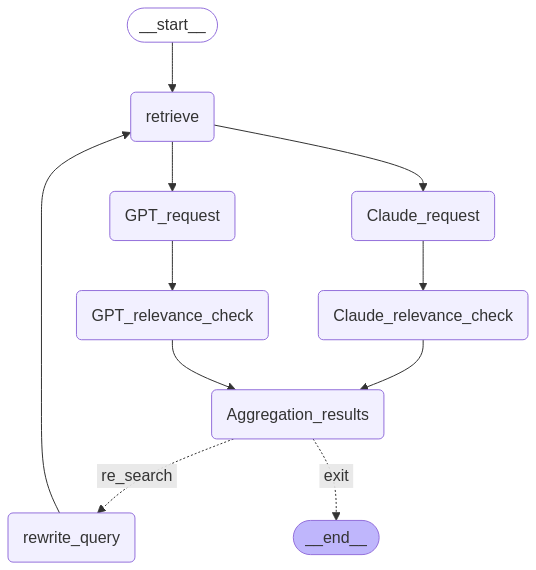

In [19]:
# Visualize the graph
display(Image(app.get_graph().draw_mermaid_png()))

### SQL RAG Graph Structure  
SQL RAG Graph là một cấu trúc kết hợp RAG truyền thống (Conventional RAG) với SQL RAG.

Nó sử dụng các "rewrite nodes" (nút viết lại) cho câu hỏi và truy vấn (query) để tạo ra kết quả chính xác dựa trên các yêu cầu.


In [21]:
# Import StateGraph and END from langgraph.graph
workflow = StateGraph(GraphState)

# Add nodes.
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("rewrite_question", rewrite_query)
workflow.add_node("GPT_request", llm_gpt_execute)
workflow.add_node("GPT_relevance_check", relevance_check)
workflow.add_node("Aggregation_results", sum_up)
workflow.add_node("get_table_info", get_table_info)
workflow.add_node("generate_sql_query", generate_sql_query)
workflow.add_node("execute_sql_query", execute_sql_query)
workflow.add_node("validate_sql_query", validate_sql_query)

# Connect nodes.
workflow.add_edge("retrieve", "get_table_info")
workflow.add_edge("get_table_info", "generate_sql_query")
workflow.add_edge("generate_sql_query", "execute_sql_query")
workflow.add_edge("execute_sql_query", "validate_sql_query")

workflow.add_conditional_edges(
    "validate_sql_query",
    decision,
    {
        "QUERY ERROR": "rewrite_query",
        "UNKNOWN MEANING": "rewrite_question",
        "PASS": "GPT_request",
    },
)

workflow.add_edge("rewrite_query", "execute_sql_query")
workflow.add_edge("rewrite_question", "rewrite_query")
workflow.add_edge("GPT_request", "GPT_relevance_check")
workflow.add_edge("GPT_relevance_check", "Aggregation_results")
workflow.add_edge("Aggregation_results", END)

# Set the entry point.
workflow.set_entry_point("retrieve")

# Set up memory storage for recording.
memory = MemorySaver()

# Compile the graph.
app = workflow.compile(checkpointer=memory)

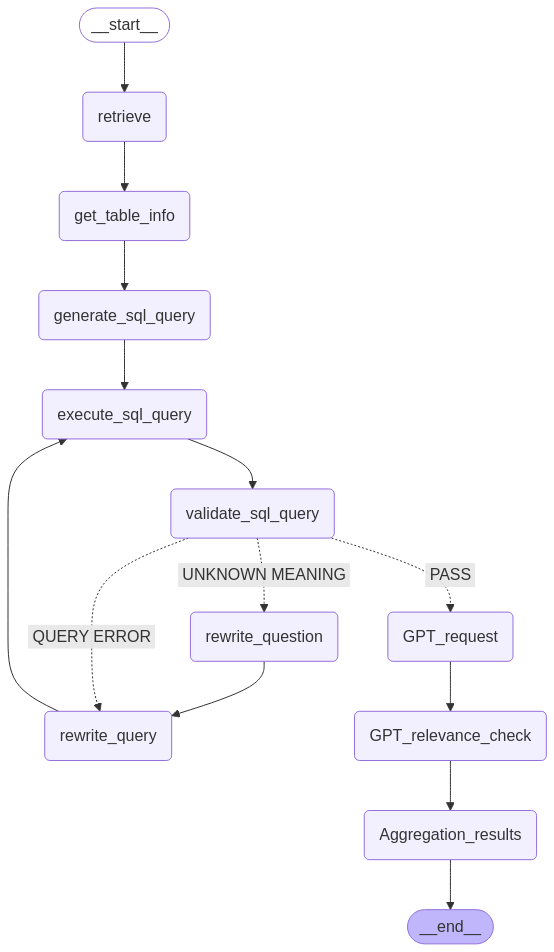

In [26]:
display(Image(app.get_graph().draw_mermaid_png()))